In [16]:
import numpy as np
import keras
import pickle
import os
import sklearn
import pandas as pd
import time 
import matplotlib.pyplot as plt

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import CuDNNLSTM
from keras.models import Sequential
from sklearn import preprocessing

import agent_components.demand.learner.lstm.lstm_preprocessing as pphelper
import importlib
importlib.reload(pphelper) #reloading own helper often, it's still changing during writing

<module 'agent_components.demand.learner.lstm.lstm_preprocessing' from '/home/pascalwhoop/Documents/Code/University/powerTAC/python-agent/agent_components/demand/learner/lstm/lstm_preprocessing.py'>

In [17]:
game = pphelper.GamesIterator().__next__()

x = np.array(game[0])
y = np.array(game[1])

In [18]:
x.shape

(199, 1569, 17)

In [19]:
y.shape

(199, 1569)

In [20]:
x[0,0]

array([10.  ,  1.  ,  0.  ,  0.  ,  0.  , -0.5 ,  0.  ,  0.  ,  0.  ,
        0.  ,  2.  ,  7.  , 24.  , 14.  , 17.  ,  0.  ,  0.24])

In [21]:
x = x.astype(np.float)
x[0,0]

array([10.  ,  1.  ,  0.  ,  0.  ,  0.  , -0.5 ,  0.  ,  0.  ,  0.  ,
        0.  ,  2.  ,  7.  , 24.  , 14.  , 17.  ,  0.  ,  0.24])

In [22]:
y = y.astype(np.float)

# Visualisation of data

## Customer data

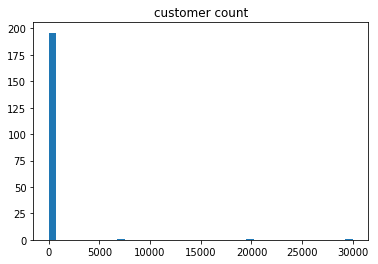

In [23]:
fig, ax = plt.subplots()
ax.hist(x[:,0,0].flatten(), 40)
ax.set_title("customer count")
plt.show()

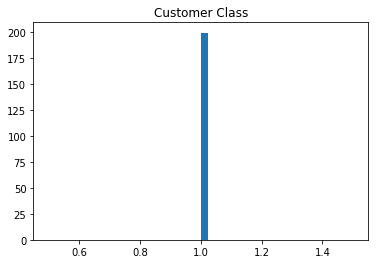

In [24]:
fig, ax = plt.subplots()
ax.hist(x[:,0,1].flatten(), 40)
ax.set_title("Customer Class")
plt.show()

The customer class variable seems quiet boring. They are all the same. But it also suggests I made a mistake here.

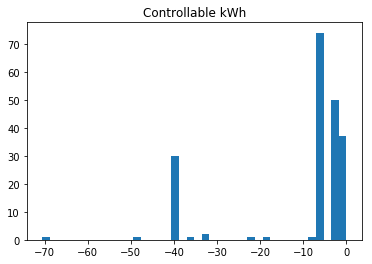

In [25]:
fig, ax = plt.subplots()
ax.hist(x[:,0,2].flatten(), 40)
ax.set_title("Controllable kWh")
plt.show()

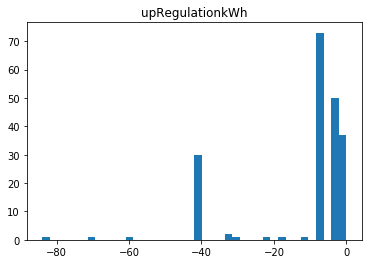

In [26]:
fig, ax = plt.subplots()
ax.hist(x[:,0,3].flatten(), 40)
ax.set_title("upRegulationkWh")
plt.show()

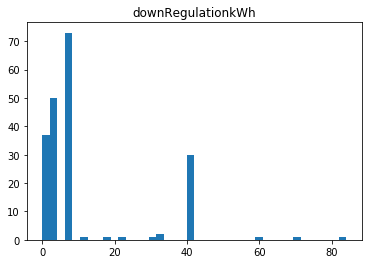

In [27]:
fig, ax = plt.subplots()
ax.hist(x[:,0,4].flatten(), 40)
ax.set_title("downRegulationkWh")
plt.show()

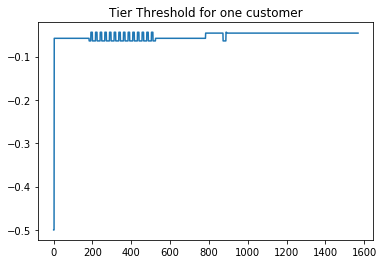

In [28]:
fig, ax = plt.subplots()
_y = x[1,:,5].flatten()
_x = np.arange(len(_y))
ax.plot(_x,_y)
ax.set_title("Tier Threshold for one customer")
plt.show()

## Weather data

`[13-17]`

*using pandas*

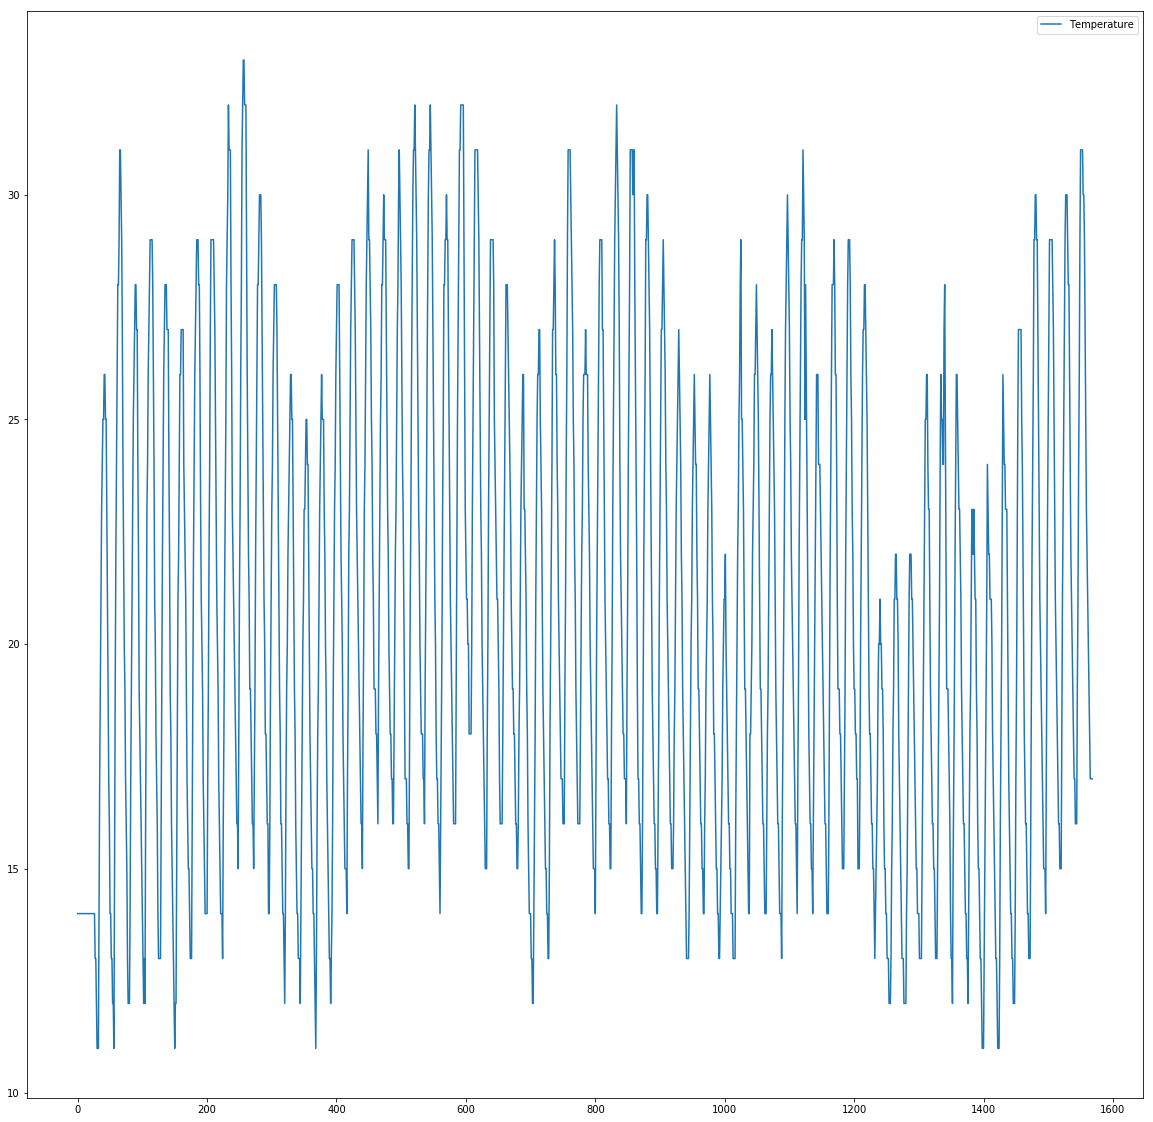

In [29]:
ts = pd.DataFrame(x[0,:,13].flatten(), columns=["Temperature"])
ts.plot(figsize=(20,20))


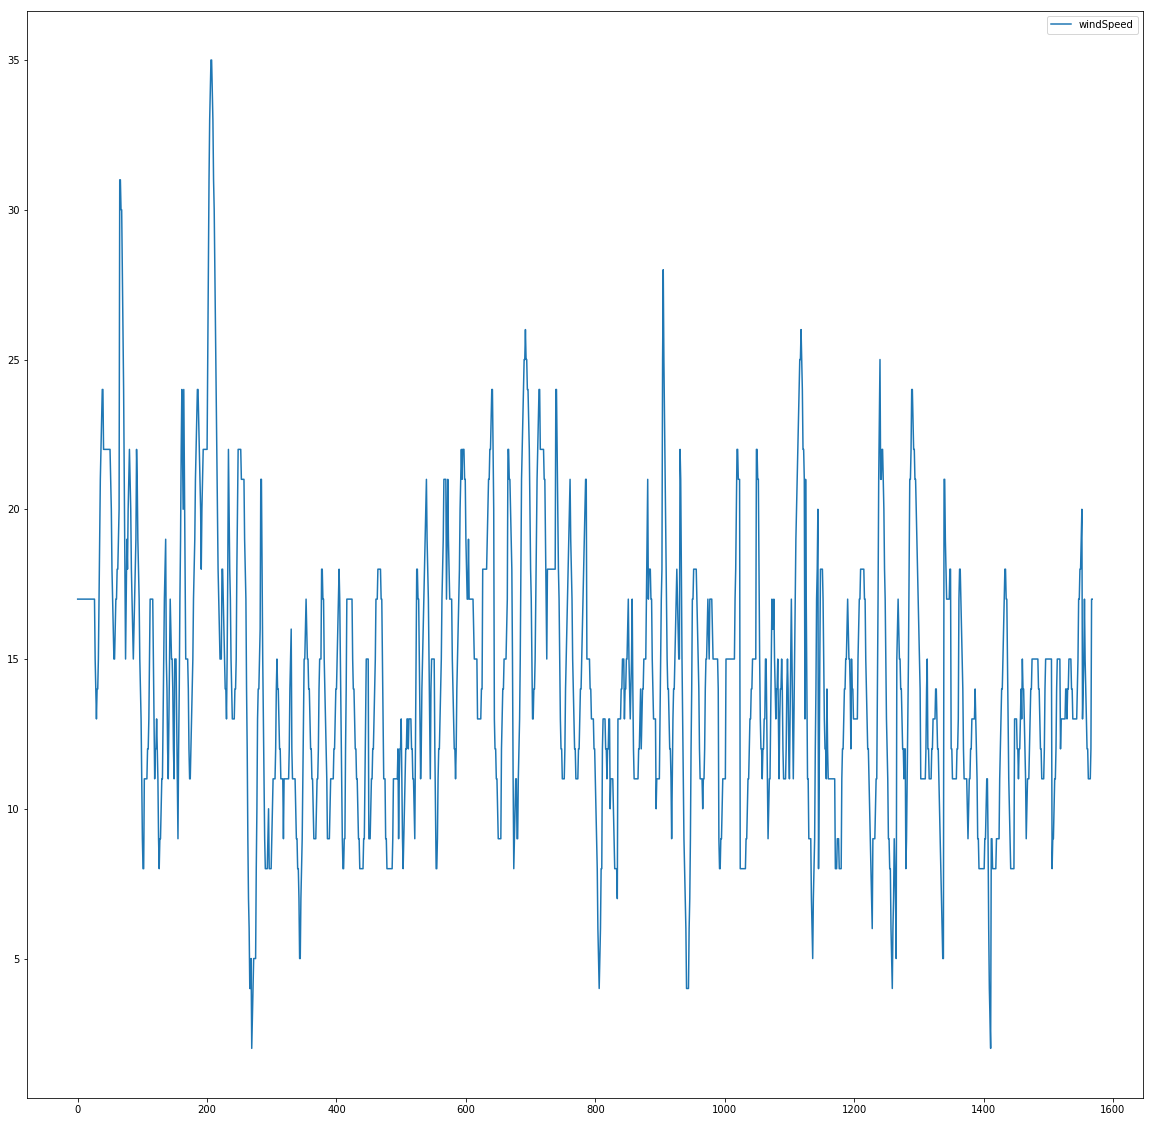

In [30]:
ts = pd.DataFrame(x[0,:,14].flatten(), columns=["windSpeed"])
ts.plot(figsize=(20,20))


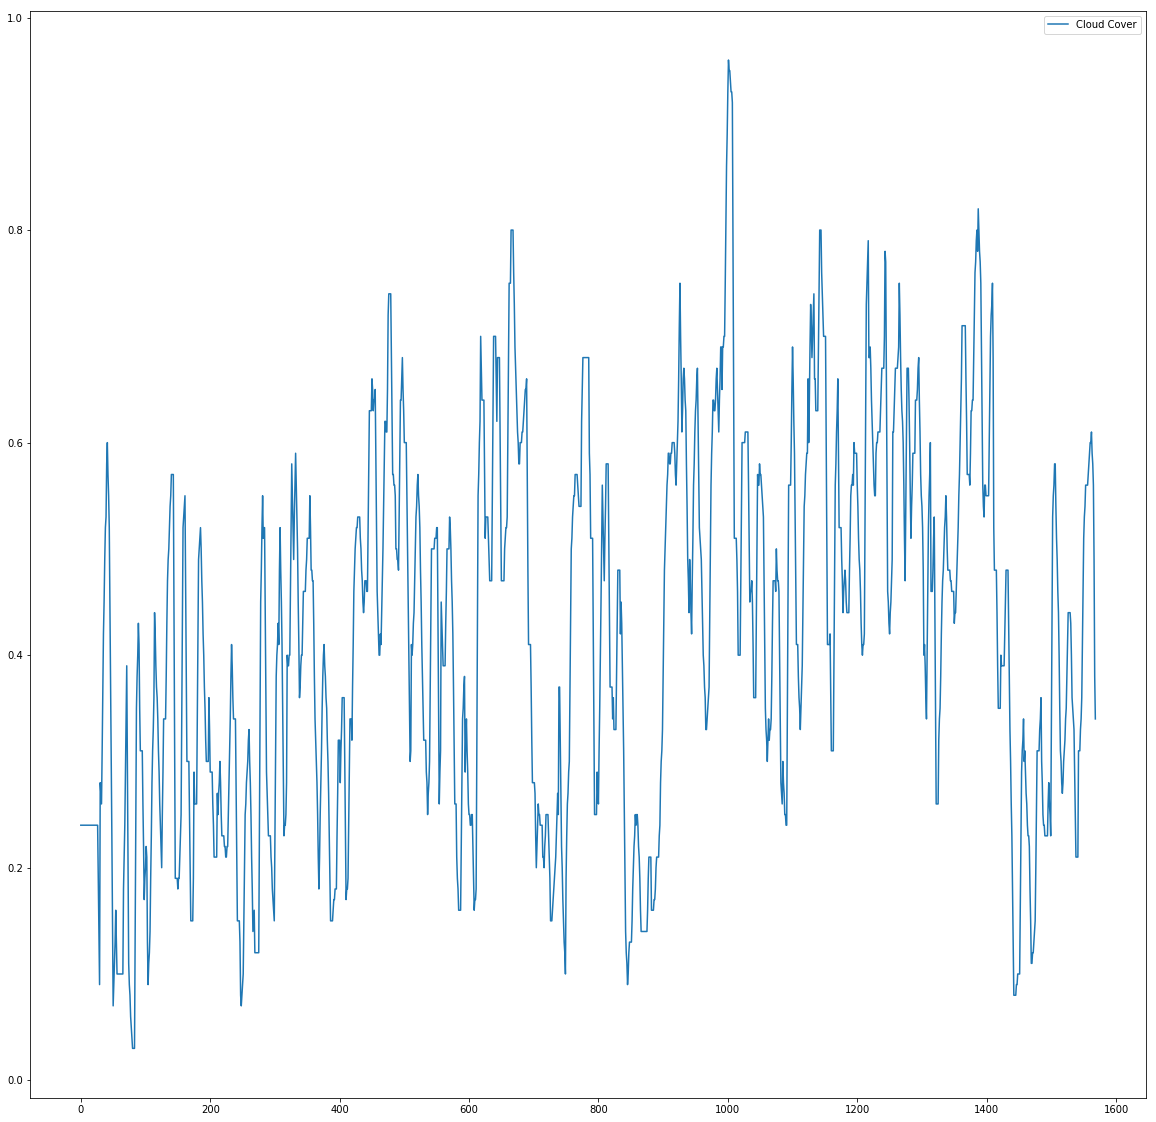

In [31]:
    ts = pd.DataFrame(x[0,:,16].flatten(), columns=["Cloud Cover"])
    ts.plot(figsize=(20,20))


(1569, 4)
(1569, 2)


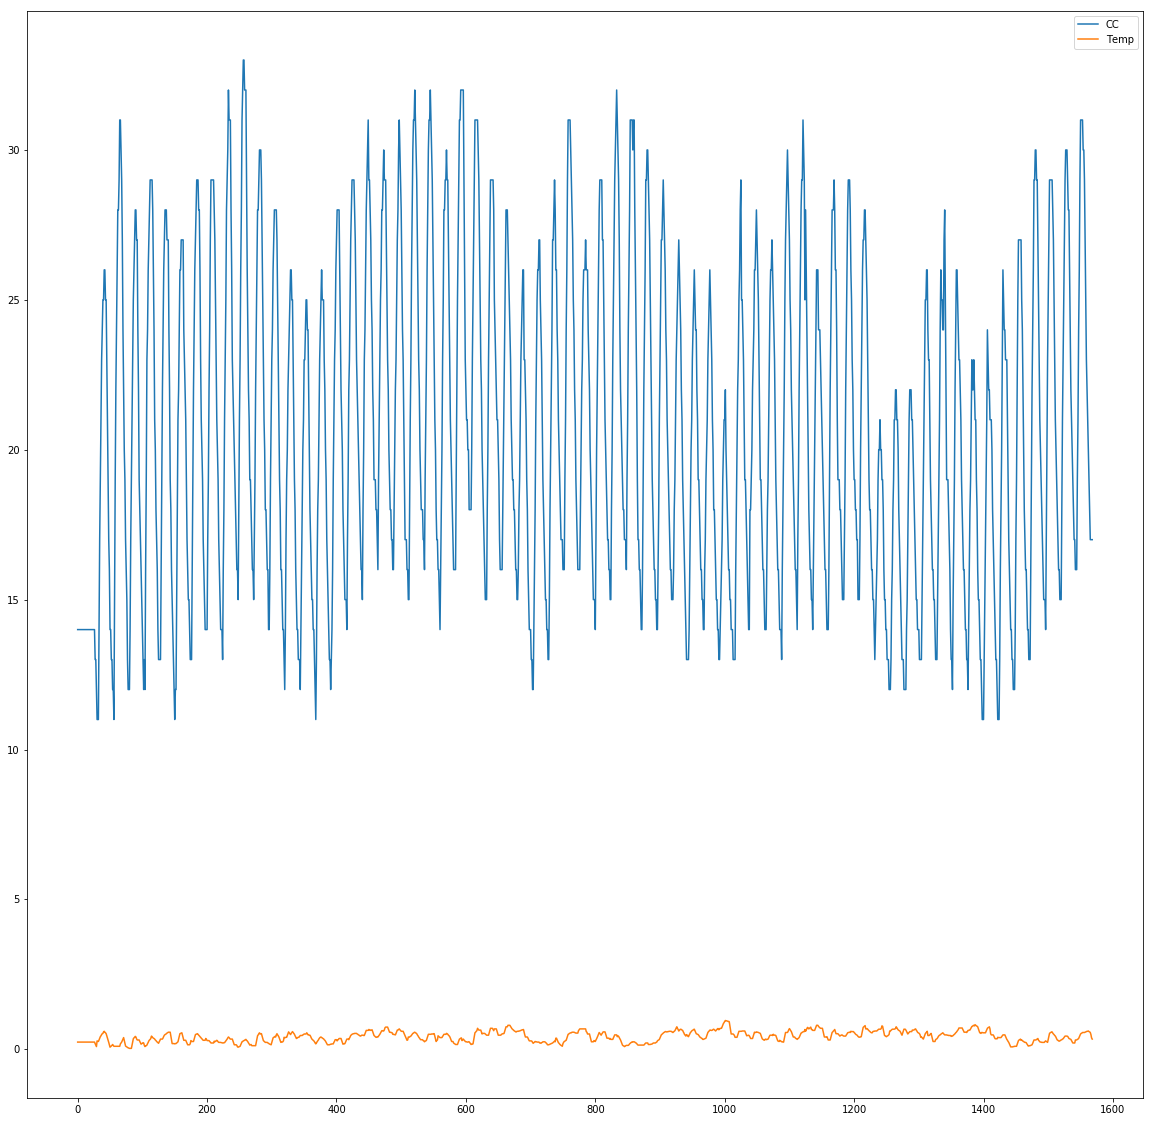

In [32]:
_x = x[0,:,13:18]
print(_x.shape)
_x = np.array([_x[:,0], _x[:,-1]]).transpose()
print(_x.shape)
ts = pd.DataFrame(_x, columns=["CC", "Temp"])
ts.plot(figsize=(20,20))

Okay let's normalize that a bit

(1569, 4)
(1569, 2)


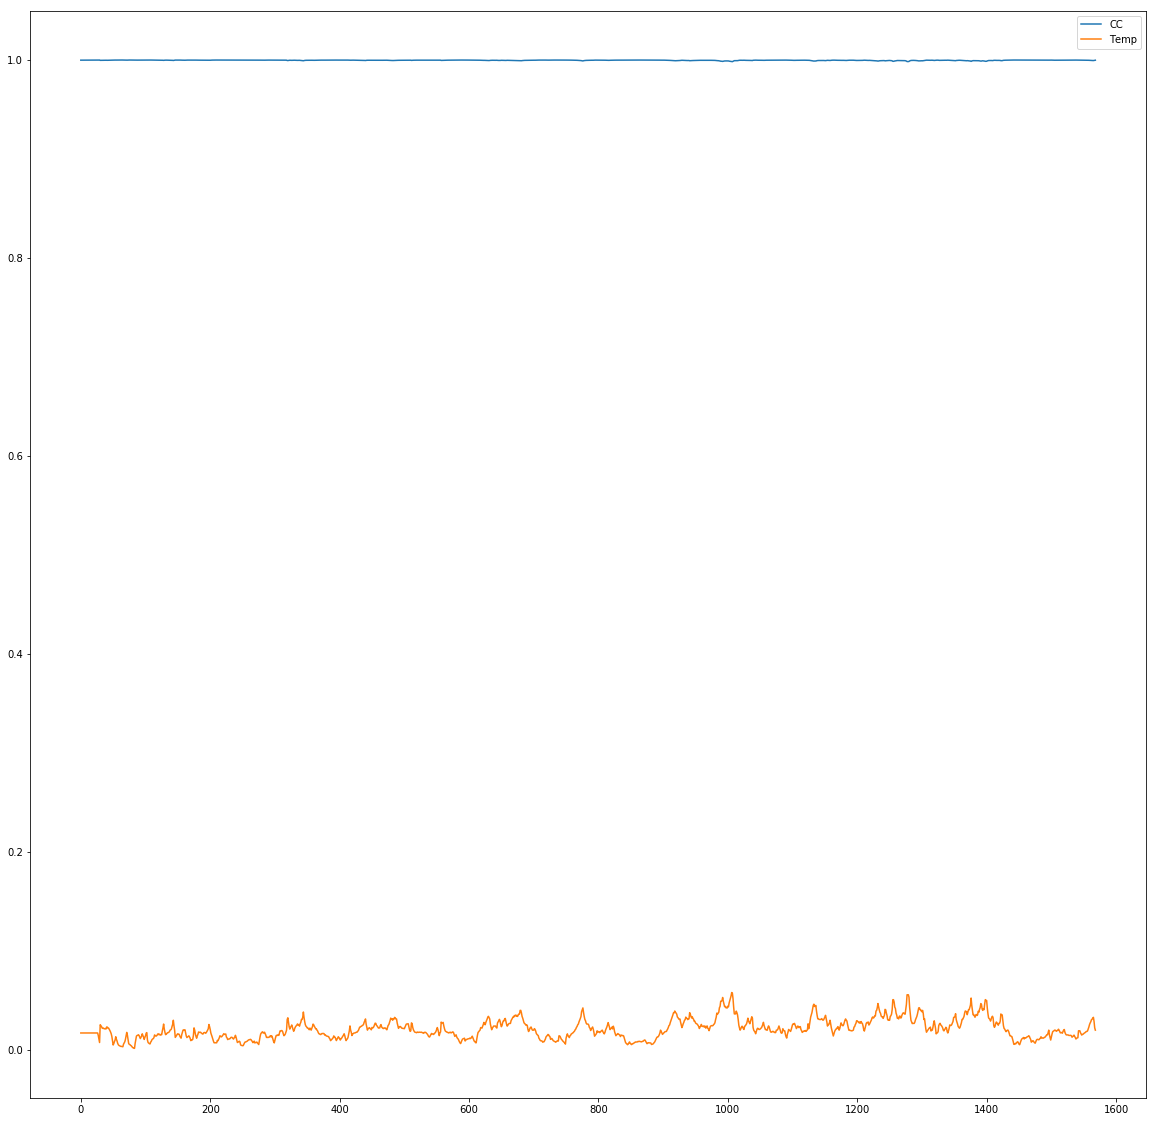

In [33]:
_x = x[0,:,13:18]
print(_x.shape)
_x = np.array([_x[:,0], _x[:,-1]]).transpose()
print(_x.shape)
_x = preprocessing.normalize(_x)
ts = pd.DataFrame(_x, columns=["CC", "Temp"])
ts.plot(figsize=(20,20))

(1569, 4)
(1569, 2)


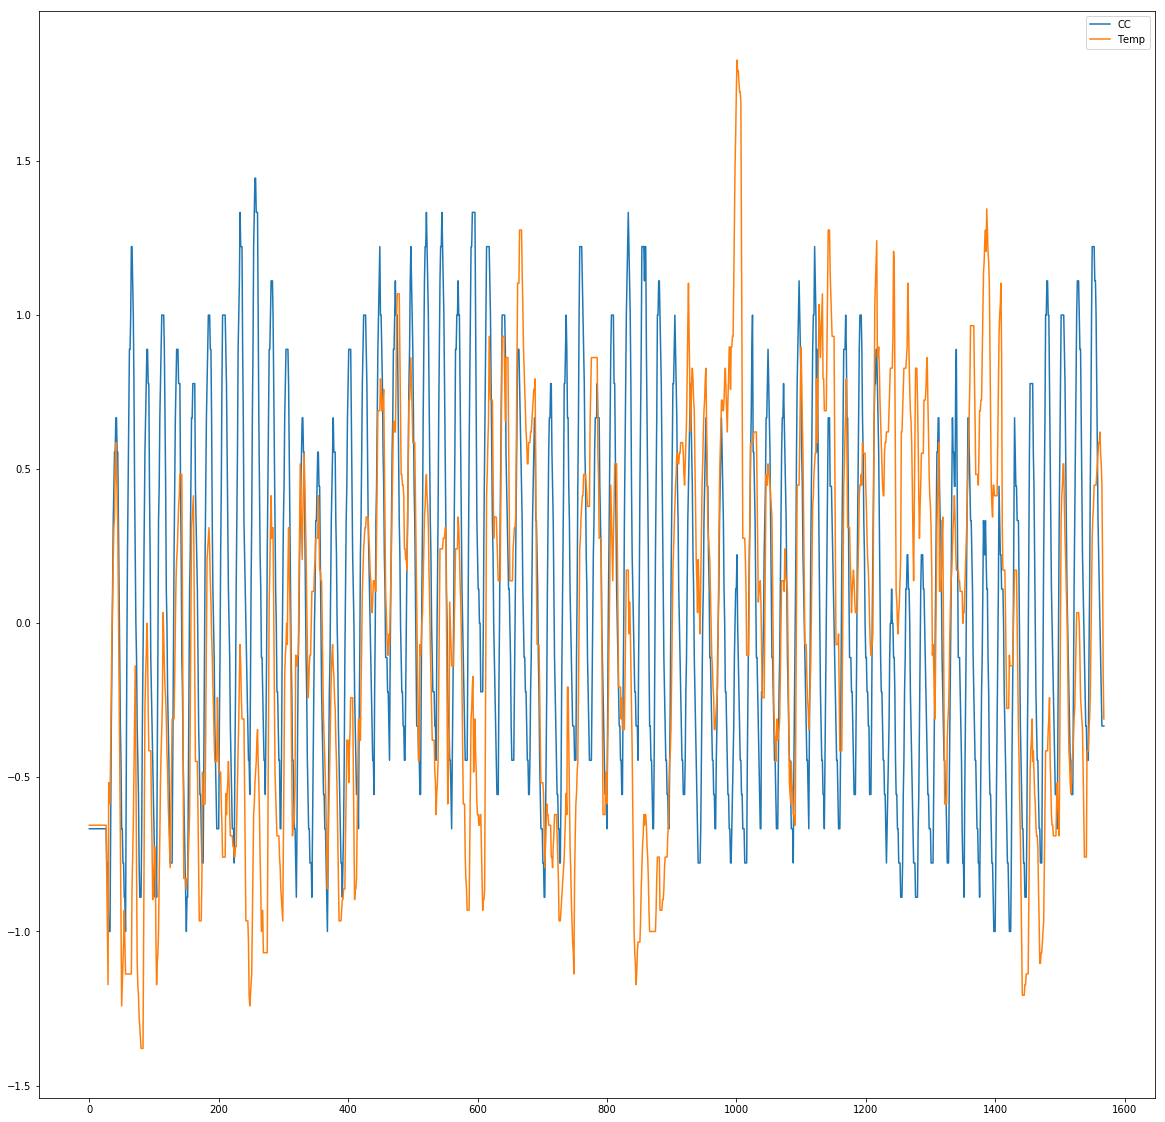

In [150]:
_x = x[0,:,13:18]
print(_x.shape)
_x = np.array([_x[:,0], _x[:,-1]]).transpose()
print(_x.shape)
_x = preprocessing.RobustScaler().fit_transform(_x)
ts = pd.DataFrame(_x, columns=["CC", "Temp"])
ts.plot(figsize=(20,20))

Creating a boxplot visualizing the RobustScaler effect on the usage data of several customers in one game. 

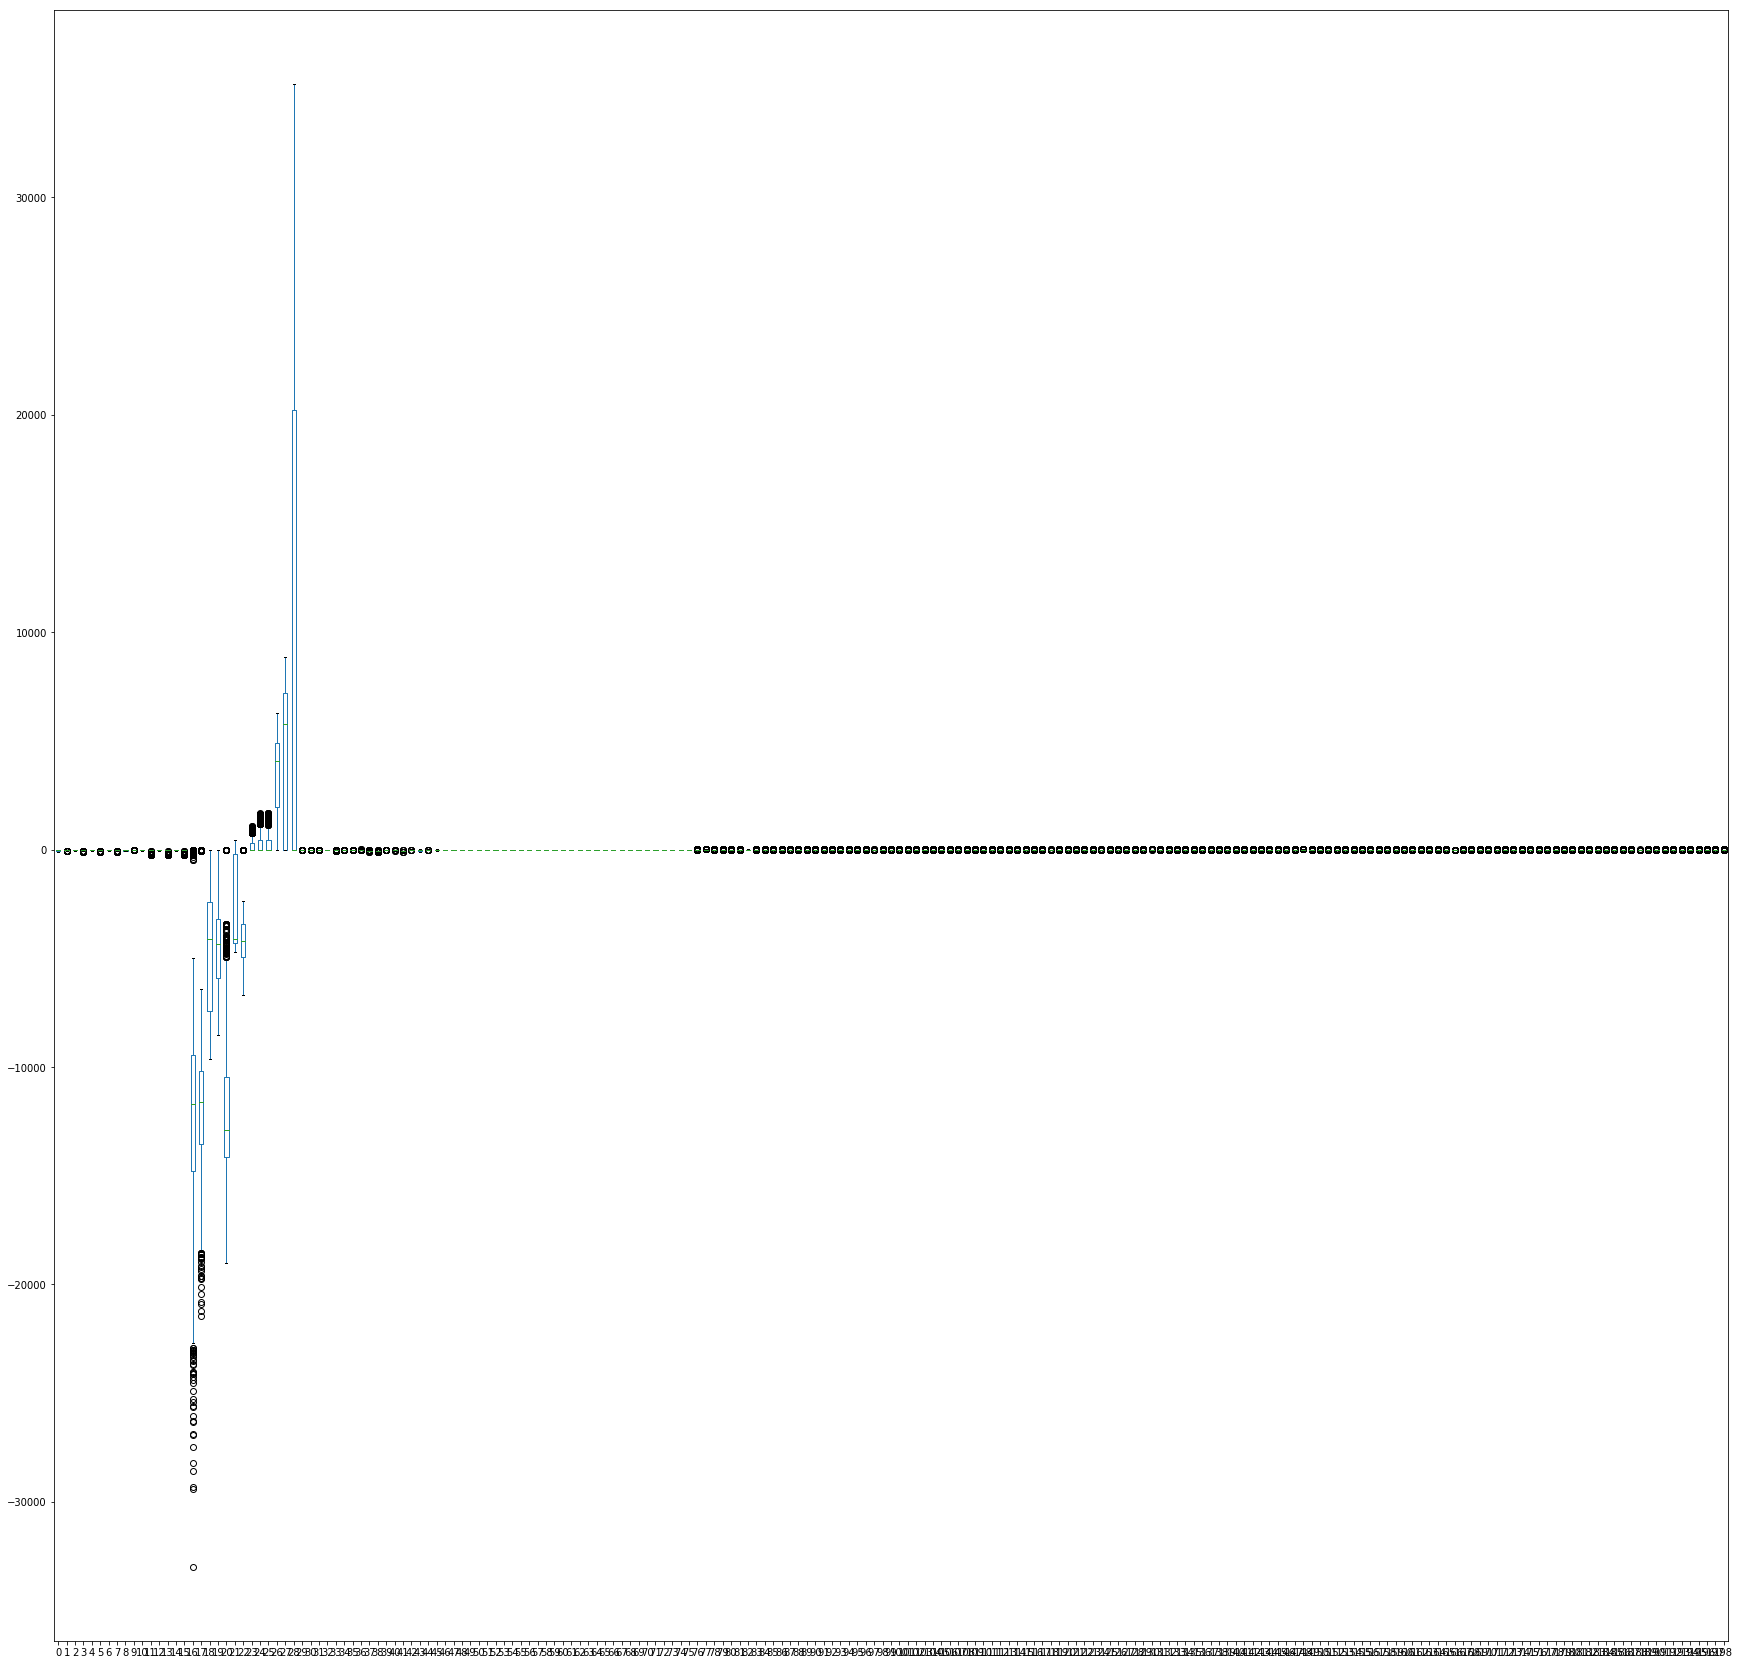

In [71]:
df = pd.DataFrame(y.transpose())
df.plot.box(figsize=(30,30))

Outliers are dominating the boxplot, whereas we want them to be better distributed

In [65]:
_data = preprocessing.RobustScaler().fit_transform(y.transpose())
print(_data.shape)

(1569, 199)


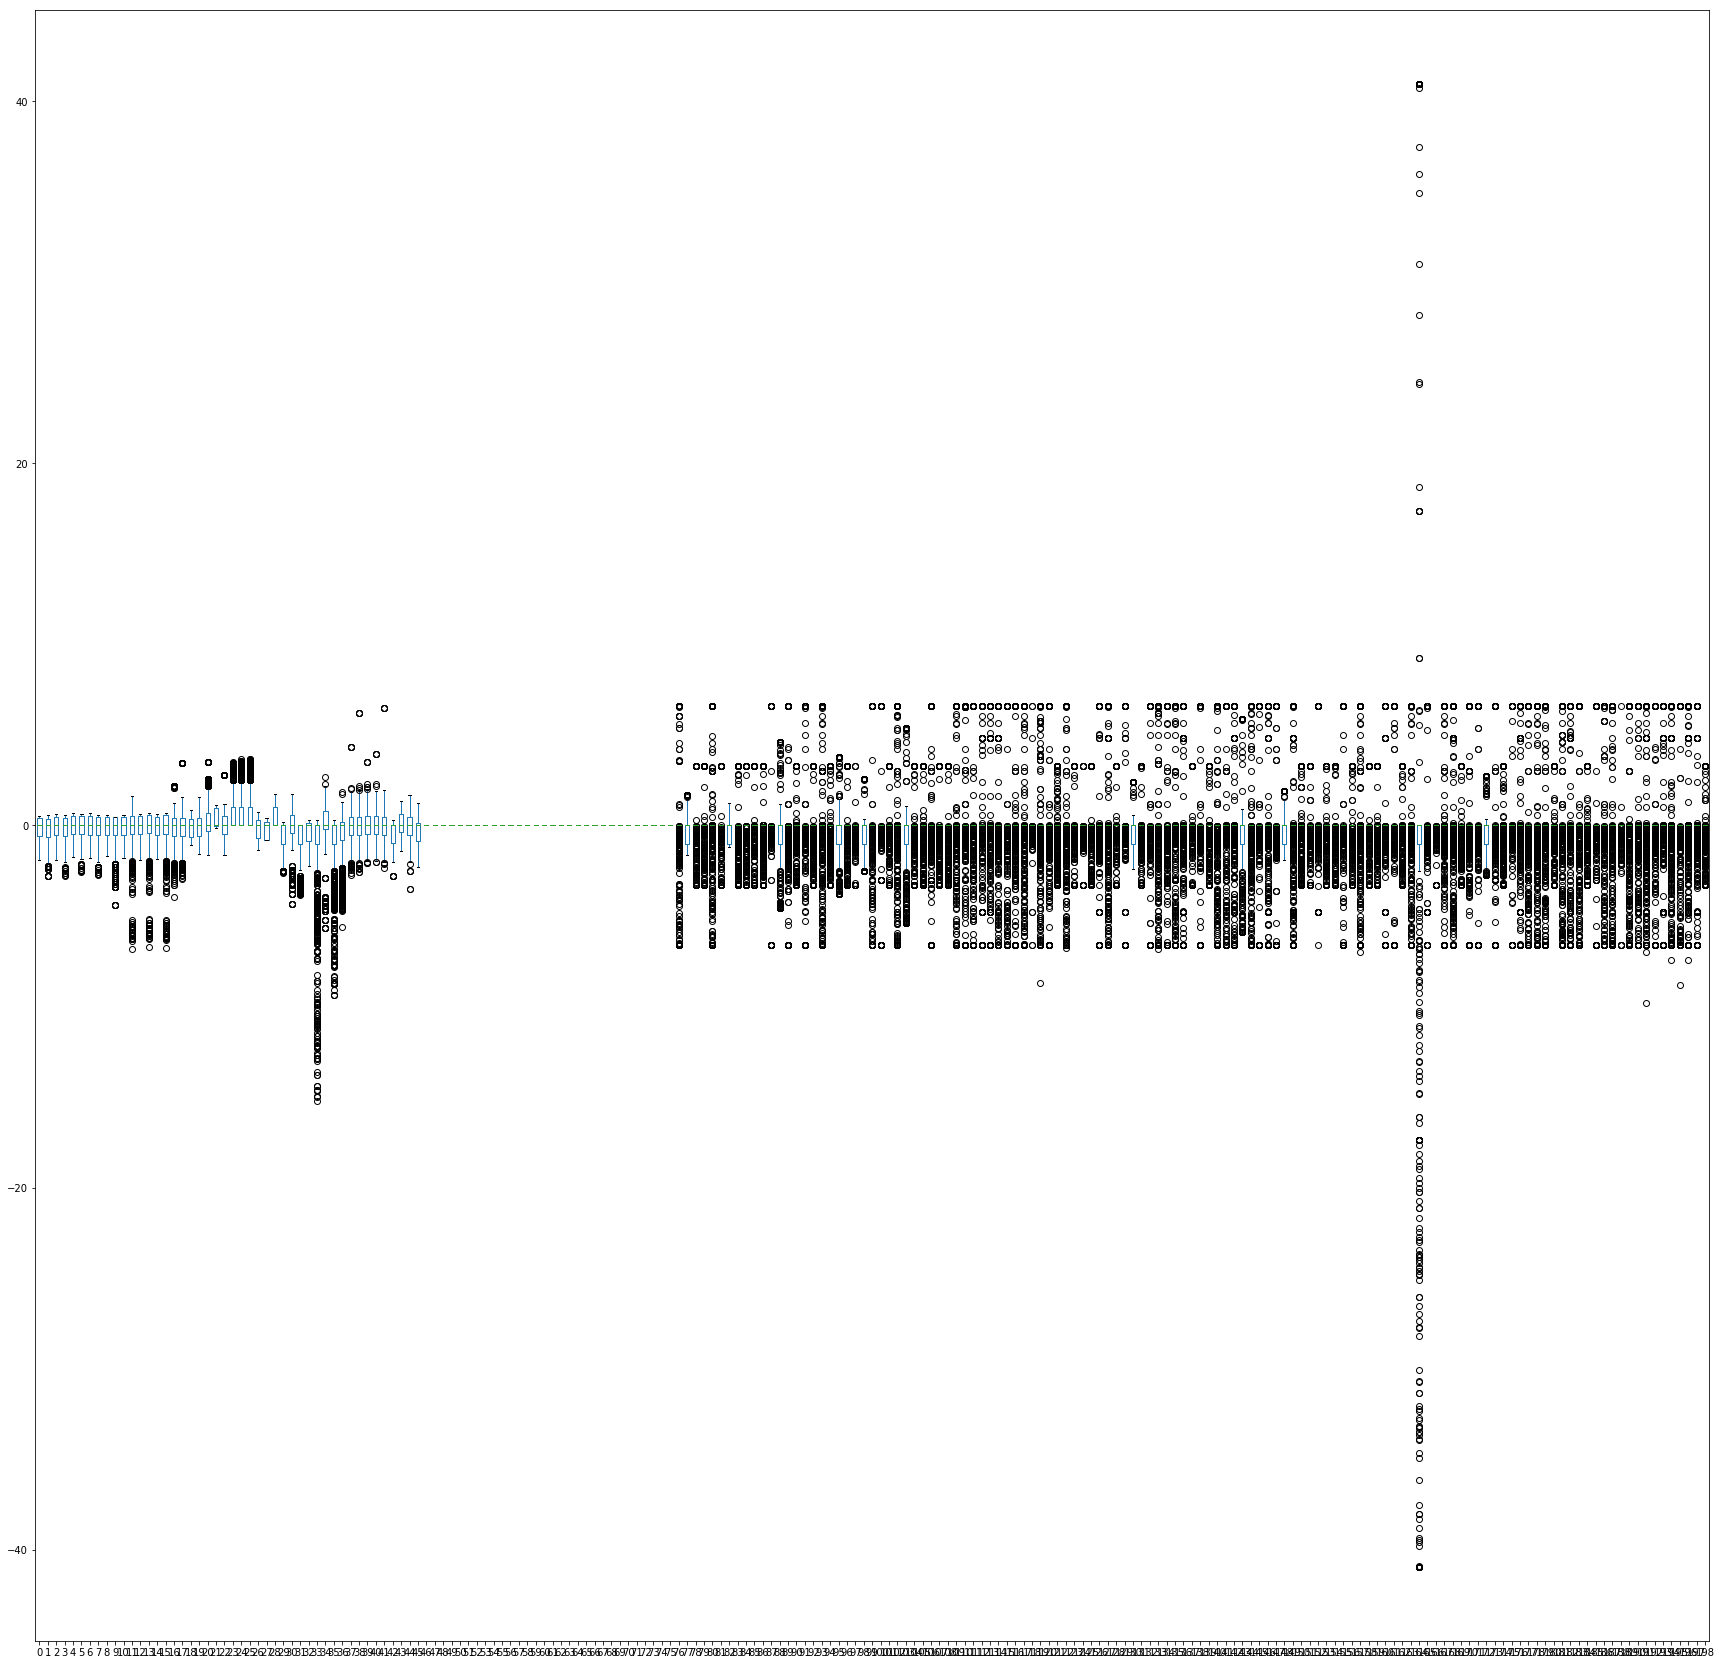

In [67]:
df = pd.DataFrame(_data)
df.plot.box(figsize=(30,30))

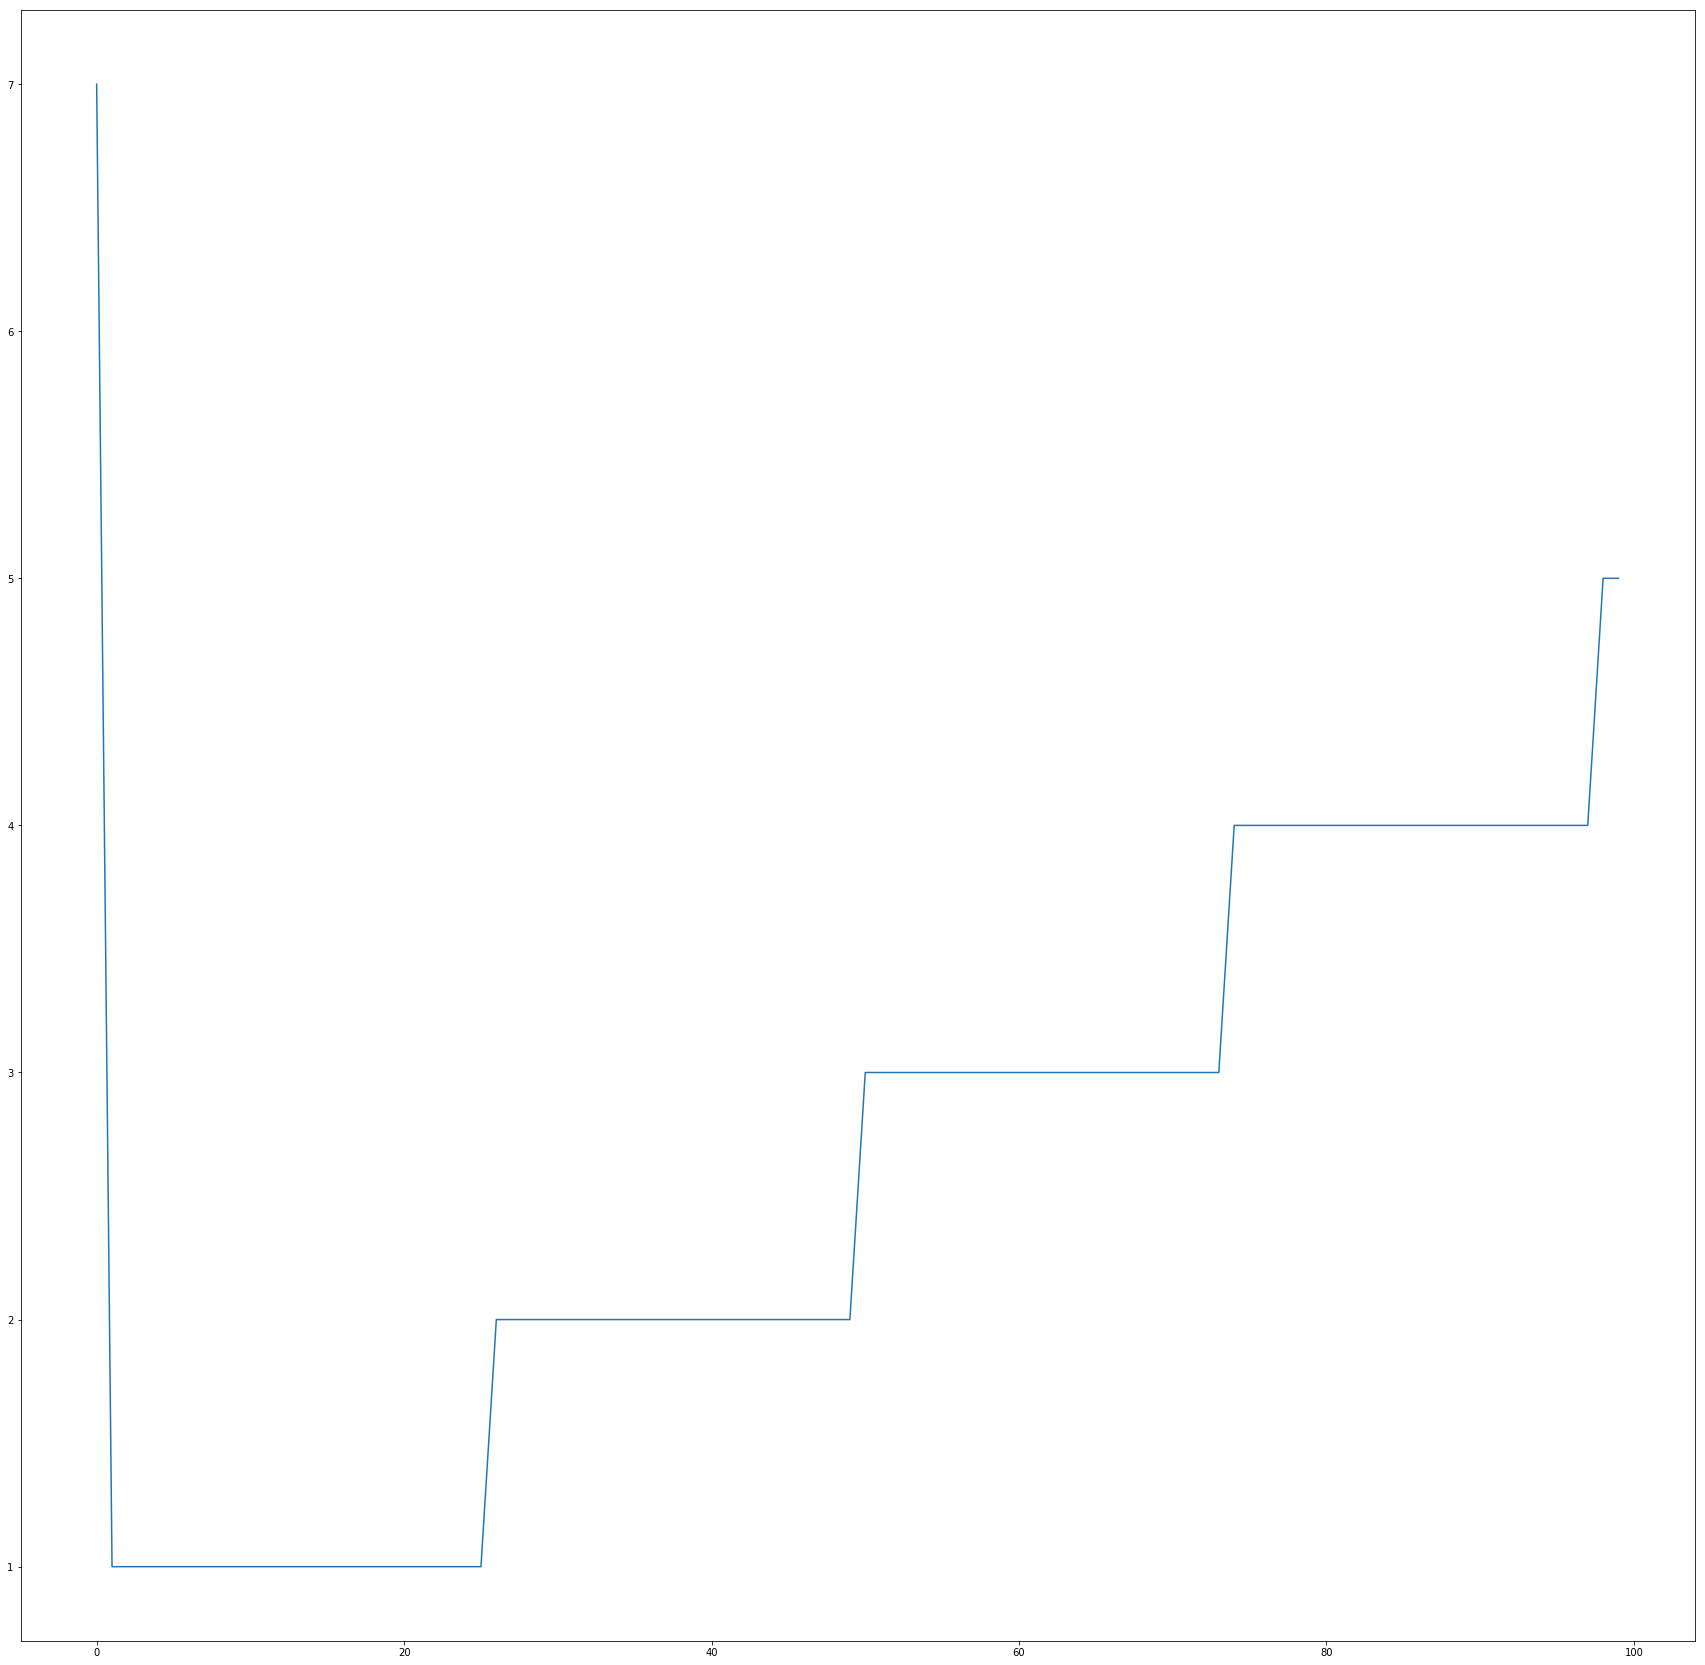

In [76]:
pd.Series(x[0,:100,11]).plot(figsize=(30,30))

Let's visualize the overall energy usage of an entire population:

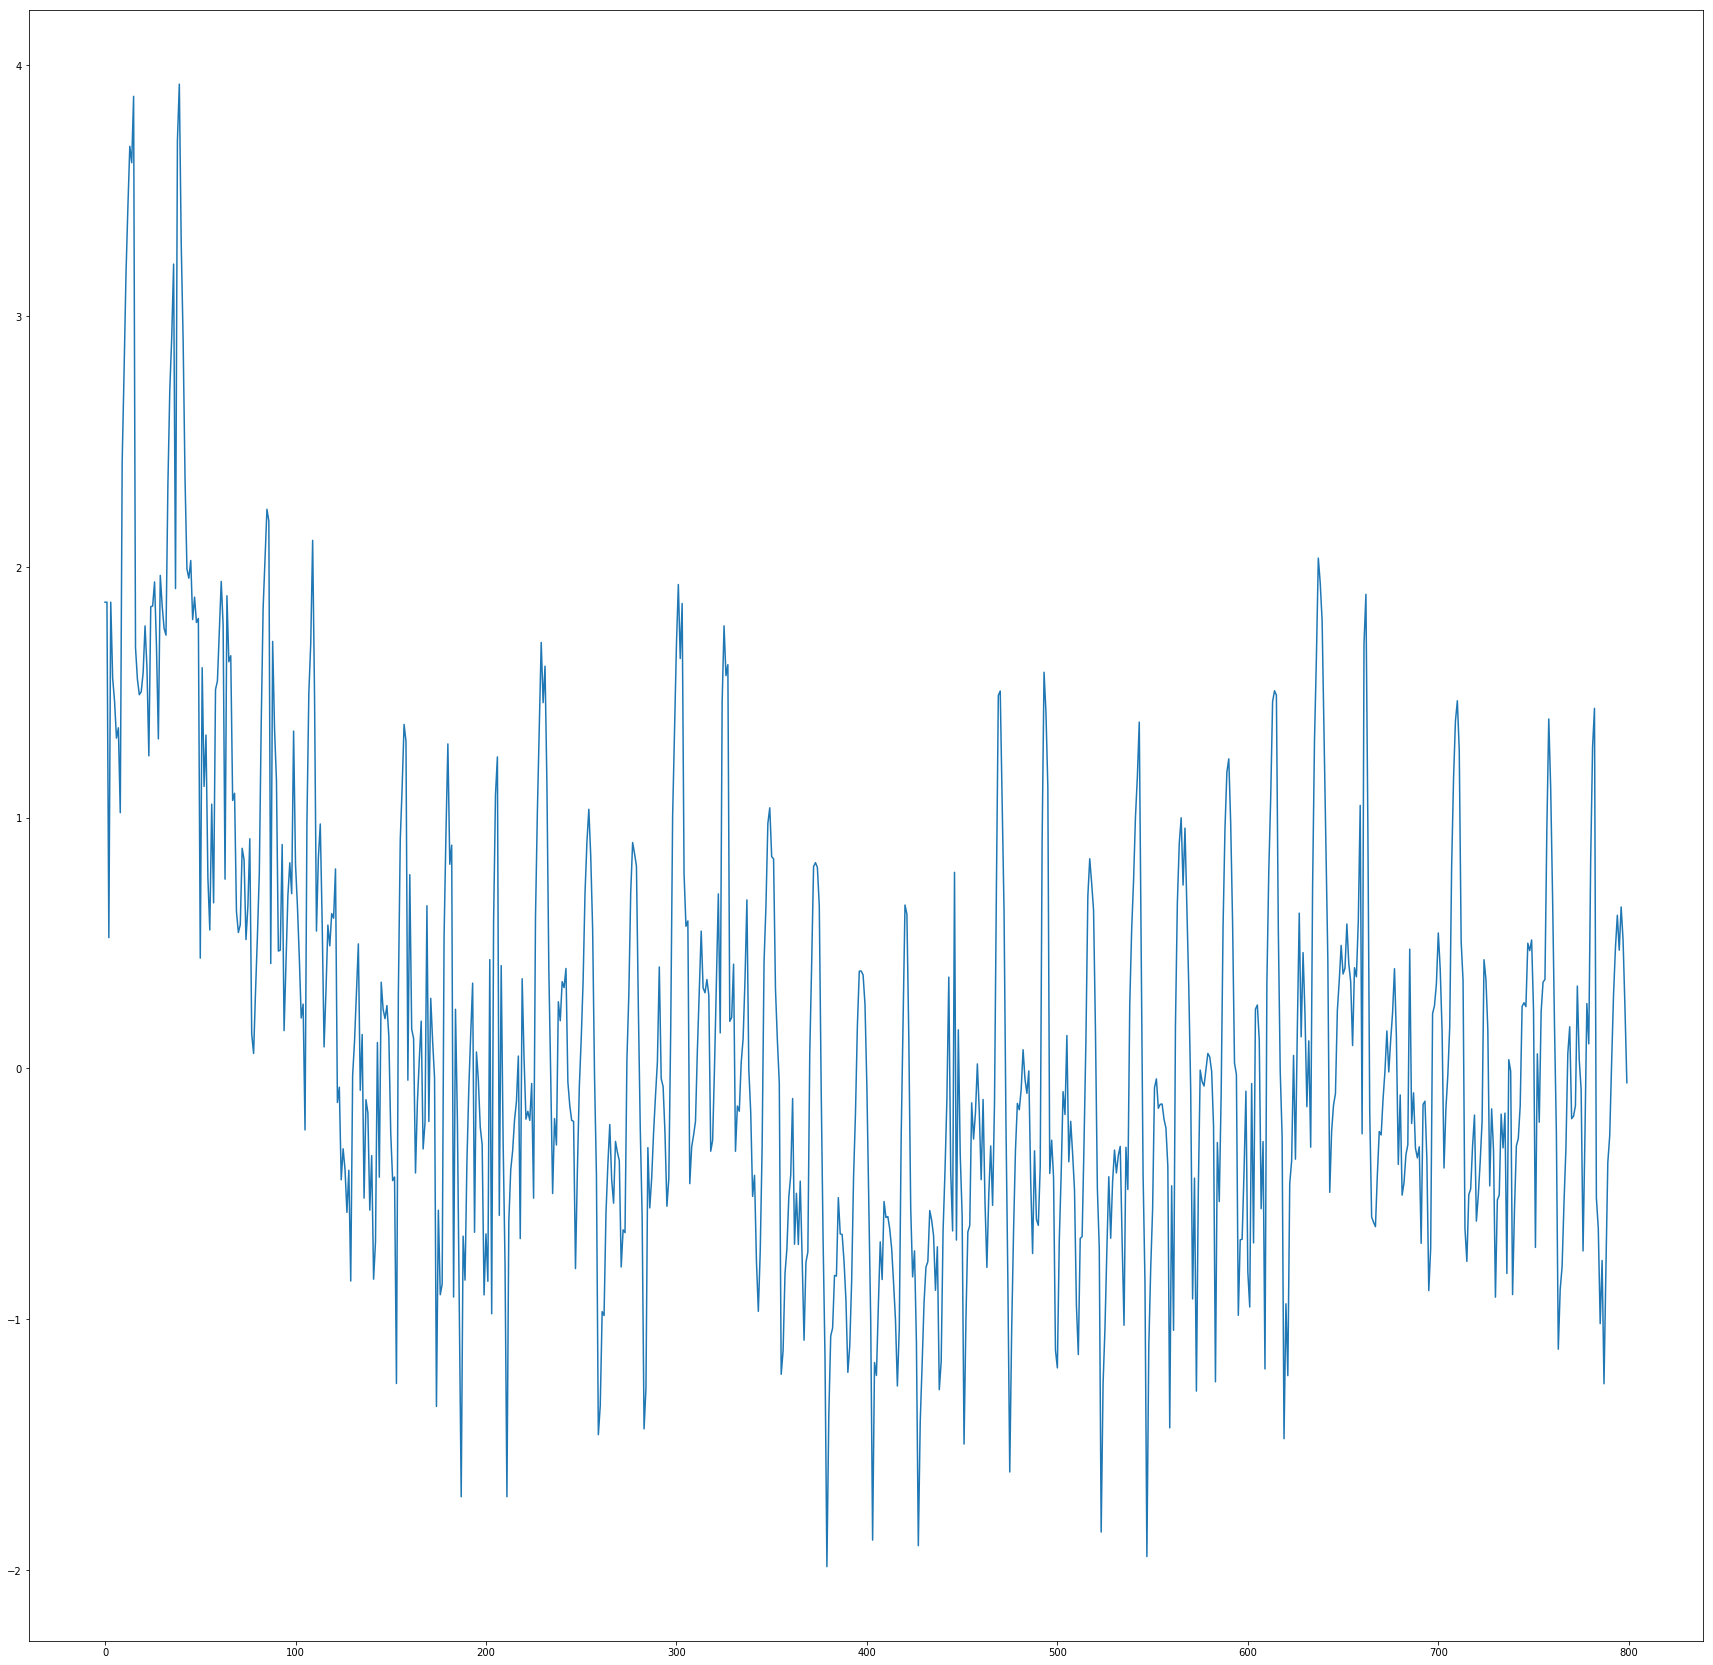

In [95]:
summed = y.sum(axis=0)
pd.Series(preprocessing.RobustScaler().fit_transform(summed.reshape(-1,1)).flatten()[:800]).plot(figsize=(30,30))

Autocorellation of the sum of the entire populations usage data

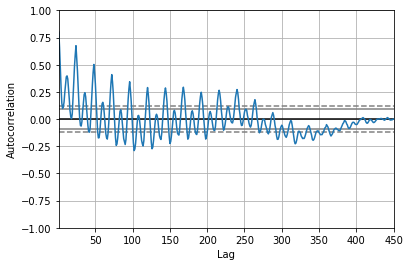

In [93]:
pd.plotting.autocorrelation_plot(pd.Series(summed[50:]))

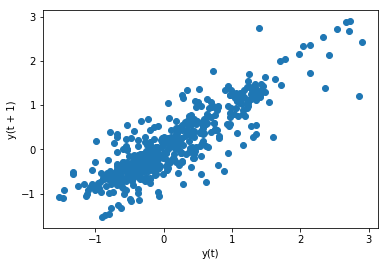

In [89]:
pd.plotting.lag_plot(pd.Series(preprocessing.RobustScaler().fit_transform(summed.reshape(-1,1)).flatten()))